## Split CIFAR-10 into training, validation, and testing sets

In [1]:
##########################
### SETTINGS
##########################

NUM_CLASSES = 10

# Hyperparameters
random_seed = 1
lr = 0.001
num_epochs = 60
batch_size = 16

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import PIL

train_transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees=(-5, 5), translate=(0.1, 0.1), scale=(0.9, 1.1), resample=PIL.Image.BILINEAR),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_set, val_set = torch.utils.data.random_split(dataset, [40000, 10000])

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=8)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1428: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


## Visualize image for each class

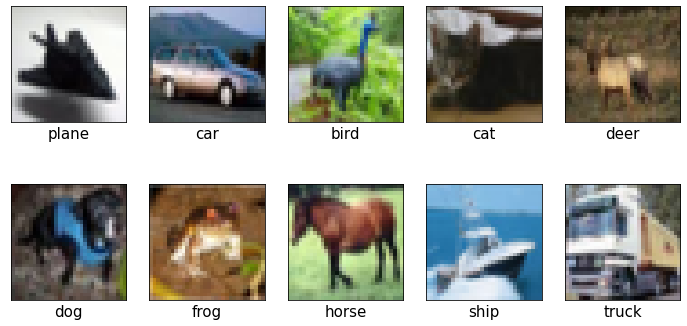

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# visualize training image for each class
sample_images = [dataset.data[np.asarray(dataset.targets) == label][0] for label in range(10)]
# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel(classes[i], fontsize=15)
    axis.imshow(sample_images[i])
    i += 1

## Define CNN architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

net = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
net.to(device)

num_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Number of trainable parameters:", num_params)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device: cuda:0
Number of trainable parameters: 61100840


## Training

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, min_lr=0)

loss_hist, acc_hist = [], []
loss_hist_val, acc_hist_val = [], []

for epoch in range(int (num_epochs/2)):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 1] loss: 0.28692 accuracy: 0.1131 val loss: 0.14050 val accuracy: 0.1496
[epoch 2] loss: 0.14127 accuracy: 0.1521 val loss: 0.13749 val accuracy: 0.1912
[epoch 3] loss: 0.13808 accuracy: 0.1805 val loss: 0.13524 val accuracy: 0.2067
[epoch 4] loss: 0.13503 accuracy: 0.1998 val loss: 0.13663 val accuracy: 0.1818
[epoch 5] loss: 0.13115 accuracy: 0.2239 val loss: 0.12595 val accuracy: 0.2615
[epoch 6] loss: 0.12280 accuracy: 0.2712 val loss: 0.11918 val accuracy: 0.2948
[epoch 7] loss: 0.11448 accuracy: 0.3145 val loss: 0.11563 val accuracy: 0.3263
[epoch 8] loss: 0.10958 accuracy: 0.3468 val loss: 0.11237 val accuracy: 0.3446
[epoch 9] loss: 0.10630 accuracy: 0.3675 val loss: 0.10538 val accuracy: 0.3701
[epoch 10] loss: 0.10346 accuracy: 0.3867 val loss: 0.10387 val accuracy: 0.4027
[epoch 11] loss: 0.10024 accuracy: 0.4078 val loss: 0.09729 val accuracy: 0.4225
[epoch 12] loss: 0.09736 accuracy: 0.4284 val loss: 0.09580 val accuracy: 0.4414
[epoch 13] loss: 0.09490 accuracy: 0.

In [6]:
from google.colab import files, drive
name = 'alexnet_weigh_epoch' + str(int(num_epochs/2)) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('alexnet_weight.pth')
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

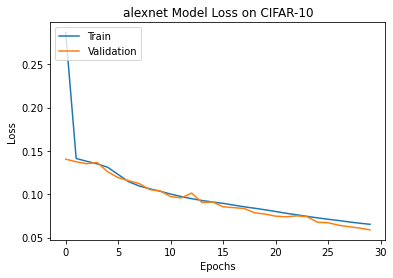

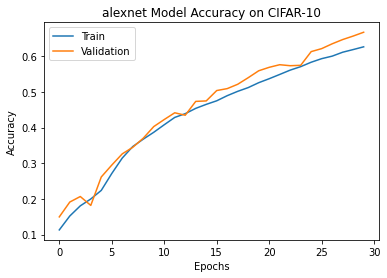

In [8]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('alexnet Model Loss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('alexnet Model Accuracy on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## **Training on 31-60**

In [9]:
for epoch in range(int (num_epochs/2), num_epochs):
  running_loss = 0.0
  correct = 0
  for data in train_loader:
    batch, labels = data
    batch, labels = batch.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(batch)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    # compute training statistics
    _, predicted = torch.max(outputs, 1)
    correct += (predicted == labels).sum().item()
    running_loss += loss.item()

  avg_loss = running_loss / len(train_set)
  avg_acc = correct / len(train_set)
  loss_hist.append(avg_loss)
  acc_hist.append(avg_acc)

  # validation statistics
  net.eval()
  with torch.no_grad():
    loss_val = 0.0
    correct_val = 0
    for data in val_loader:
      batch, labels = data
      batch, labels = batch.to(device), labels.to(device)
      outputs = net(batch)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs, 1)
      correct_val += (predicted == labels).sum().item()
      loss_val += loss.item()
    avg_loss_val = loss_val / len(val_set)
    avg_acc_val = correct_val / len(val_set)
    loss_hist_val.append(avg_loss_val)
    acc_hist_val.append(avg_acc_val)
  net.train()

  scheduler.step(avg_loss_val)
  print('[epoch %d] loss: %.5f accuracy: %.4f val loss: %.5f val accuracy: %.4f' % (epoch + 1, avg_loss, avg_acc, avg_loss_val, avg_acc_val))

[epoch 31] loss: 0.06375 accuracy: 0.6361 val loss: 0.06097 val accuracy: 0.6579
[epoch 32] loss: 0.06250 accuracy: 0.6439 val loss: 0.05734 val accuracy: 0.6731
[epoch 33] loss: 0.06122 accuracy: 0.6530 val loss: 0.05885 val accuracy: 0.6666
[epoch 34] loss: 0.05991 accuracy: 0.6579 val loss: 0.05468 val accuracy: 0.6937
[epoch 35] loss: 0.05862 accuracy: 0.6660 val loss: 0.05607 val accuracy: 0.6823
[epoch 36] loss: 0.05772 accuracy: 0.6722 val loss: 0.05253 val accuracy: 0.7066
[epoch 37] loss: 0.05659 accuracy: 0.6780 val loss: 0.05117 val accuracy: 0.7142
[epoch 38] loss: 0.05537 accuracy: 0.6866 val loss: 0.05135 val accuracy: 0.7177
[epoch 39] loss: 0.05440 accuracy: 0.6952 val loss: 0.05279 val accuracy: 0.7117
[epoch 40] loss: 0.05333 accuracy: 0.6995 val loss: 0.04970 val accuracy: 0.7244
[epoch 41] loss: 0.05207 accuracy: 0.7044 val loss: 0.04790 val accuracy: 0.7323
[epoch 42] loss: 0.05131 accuracy: 0.7096 val loss: 0.05175 val accuracy: 0.7116
[epoch 43] loss: 0.05037 acc

In [10]:
from google.colab import files, drive
name = 'alexnet_weigh_epoch' + str(num_epochs) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('alexnet_weight.pth')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

## Plotting training statistics

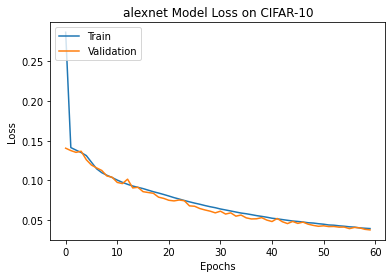

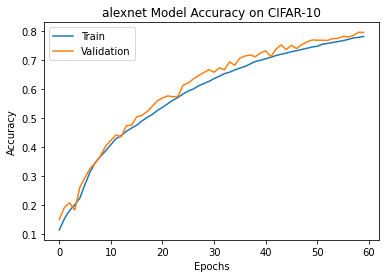

In [12]:
import matplotlib.pyplot as plt

legend = ['Train', 'Validation']
plt.plot(loss_hist)
plt.plot(loss_hist_val)
plt.title('alexnet Model Loss on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(legend, loc='upper left')
plt.show()

legend = ['Train', 'Validation']
plt.plot(acc_hist)
plt.plot(acc_hist_val)
plt.title('alexnet Model Accuracy on CIFAR-10')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(legend, loc='upper left')
plt.show()

## Save the trained model

In [13]:
from google.colab import files, drive
name = 'alexnet_weigh_epoch' + str(num_epochs) + '.pth'
torch.save(net.state_dict(), name)
# download checkpoint file
# files.download('alexnet_weight.pth')
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [14]:
net.load_state_dict(torch.load(name))

<All keys matched successfully>

## Testing

In [15]:
pred_vec = []
correct = 0
net.eval()
with torch.no_grad():
    for data in test_loader:
        batch, labels = data
        batch, labels = batch.to(device), labels.to(device)
        outputs = net(batch)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        pred_vec.append(predicted)
    pred_vec = torch.cat(pred_vec)

print('Accuracy on the 10000 test images: %.2f %%' % (100 * correct / len(test_set)))

Accuracy on the 10000 test images: 79.37 %


## Visualize wrongly classified image for each class

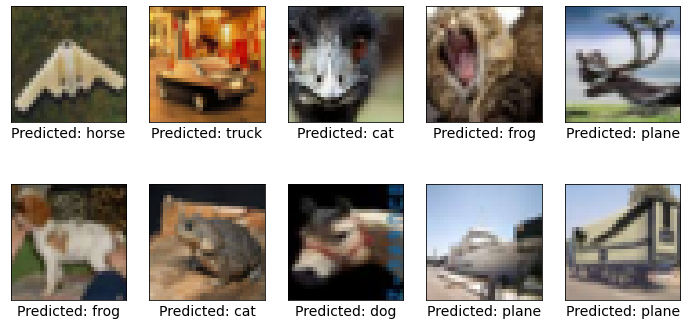

In [16]:
import numpy as np

# visualize wrongly classified image for each class
pred_vec = pred_vec.cpu().numpy()
ground_truths = np.asarray(test_set.targets)
incorrect_mask = pred_vec != ground_truths
incorrect_images = [test_set.data[(ground_truths == label) & incorrect_mask][0] for label in range(10)]
pred_results = [pred_vec[(ground_truths == label) & incorrect_mask][0] for label in range(10)]

# show images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
i = 0
for row in axes:
  for axis in row:
    axis.set_xticks([])
    axis.set_yticks([])
    axis.set_xlabel("Predicted: %s" % classes[pred_results[i]], fontsize=14)
    axis.imshow(incorrect_images[i])
    i += 1